# Project

In [1]:
# import zipfile
# with zipfile.ZipFile("./data_red.zip", 'r') as zip_ref:
#     zip_ref.extractall("./")

In [2]:
import os
os.environ['SKIMAGE_DATADIR'] = '/tmp/.skimage_cache'

In [3]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image Processing
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import shannon_entropy, perimeter

# Data Preprocessing and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score,
                             recall_score, f1_score)
import shap

# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier)
from xgboost import XGBClassifier

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2ulmj9n2 because the default path (/home/fgarcia/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
def dt(X, y, X_test=None, y_test=None, cv=10, feat_imp=False, default=False):
    # GridSearchCV
    model = DecisionTreeClassifier()
    scoring = 'recall'
    cv = cv
    max_depth = [3, 5, 7, 10, 15, 20, 25, 30, 40, 50]

    # Checks if default
    if default == True:
        param_grid = {}
    else:
        param_grid = {'max_depth': max_depth}

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # If train-validate-test
    if X_test is not None:
        test_score = best_estimator.score(X_test, y_test)

    # Feature Importance Plot
    if feat_imp == True:
        fig, ax = plt.subplots(figsize=(4, 6))
        sorted_index = np.argsort(abs(feature_imp))
        ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
        ax.set_title('Decision Tree Feature Importance Plot', weight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()

    return ['Decision Tree',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            test_score,
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]


def rf(X, y, X_test=None, y_test=None, cv=10, feat_imp=False, default=False):
    # GridSearchCV
    model = RandomForestClassifier()
    scoring = 'recall'
    cv = cv
    n_estimators = [100, 150, 200, 250]
    max_depth = [3, 5, 10, 20, 30, 50]

    # Checks if default
    if default == True:
        param_grid = {}
    else:
        param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # If train-validate-test
    if X_test is not None:
        test_score = best_estimator.score(X_test, y_test)

    # Feature Importance Plot
    if feat_imp == True:
        fig, ax = plt.subplots(figsize=(4, 6))
        sorted_index = np.argsort(abs(feature_imp))
        ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
        ax.set_title('Random Forest Feature Importance Plot', weight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()

    return ['Random Forest',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            test_score,
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]


def gbm(X, y, X_test=None, y_test=None, cv=10, feat_imp=False, default=False):
    # GridSearchCV
    model = GradientBoostingClassifier()
    scoring = 'recall'
    cv = cv
    n_estimators = [100, 200]
    max_depth = [3, 5, 7]
    max_features = [0.5, 0.7, 0.9]
    learning_rate = [0.01, 0.1, 1]

    # Checks if default
    if default == True:
        param_grid = {}
    else:
        param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
                      'max_features': max_features,
                      'learning_rate': learning_rate}

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=cv, scoring=scoring,
                               return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # If train-validate-test
    if X_test is not None:
        test_score = best_estimator.score(X_test, y_test)

    # Feature Importance Plot
    if feat_imp == True:
        fig, ax = plt.subplots(figsize=(4, 6))
        sorted_index = np.argsort(abs(feature_imp))
        ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
        ax.set_title('Gradient Boosting Method Feature Importance Plot',
                     weight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()

    return ['Gradient Boosting Method',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            test_score,
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]


def xg(X, y, X_test=None, y_test=None, cv=10, feat_imp=False, default=False):
    # GridSearchCV
    model = XGBClassifier(tree_method="hist")
    scoring = 'recall'
    cv = cv
    n_estimators = [100, 150, 200]
    max_depth = [1, 3, 5, 7]
    subsample = [0.5, 0.7, 0.9]
    eta = [0.01, 0.1, 1]

    # Checks if default
    if default == True:
        param_grid = {}
    else:
        param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
                      'subsample': subsample, 'eta': eta}

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=cv, scoring=scoring,
                               return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # If train-validate-test
    if X_test is not None:
        test_score = best_estimator.score(X_test, y_test)

    # Feature Importance Plot
    if feat_imp == True:
        fig, ax = plt.subplots(figsize=(4, 6))
        sorted_index = np.argsort(abs(feature_imp))
        ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
        ax.set_title('XGBoost Feature Importance Plot', weight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()

    return ['XGBoost',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            test_score,
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]


def ada(X, y, X_test=None, y_test=None, cv=10, feat_imp=False, default=False):
    # GridSearchCV
    model = AdaBoostClassifier()
    scoring = 'recall'
    cv = cv
    n_estimators = [100, 150, 200]
    learning_rate = [0.01, 0.1, 1]

    # Checks if default
    if default == True:
        param_grid = {}
    else:
        param_grid = {'n_estimators': n_estimators,
                      'learning_rate': learning_rate}

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=cv, scoring=scoring,
                               return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # If train-validate-test
    if X_test is not None:
        test_score = best_estimator.score(X_test, y_test)

    # Feature Importance Plot
    if feat_imp == True:
        fig, ax = plt.subplots(figsize=(4, 6))
        sorted_index = np.argsort(abs(feature_imp))
        ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
        ax.set_title('AdaBoost Feature Importance Plot', weight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()

    return ['AdaBoost',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            test_score,
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]


def Auto_Grid_Search_Classification_TVT(X_scaled, y, X_test=None, y_test=None,
                                        cv=10, feat_imp=False,
                                        default=False, models=[]):
    # Summary Table
    pd.set_option('display.max_colwidth', None)
    cols = ['Machine Learning Method', 'Train Accuracy',
            'Validation Accuracy', 'Test Accuracy', 'Optimal Parameter',
            'Top Predictor', 'Run Time']
    df_summary = pd.DataFrame(columns=cols)

    for i, model in enumerate(models):
        if model == 'dt':
            df_summary.loc[i] = dt(X_scaled, y, X_test=X_test, y_test=y_test,
                                   cv=cv, feat_imp=feat_imp, default=default)
        elif model == 'rf':
            df_summary.loc[i] = rf(X_scaled, y, X_test=X_test, y_test=y_test,
                                   cv=cv, feat_imp=feat_imp, default=default)
        elif model == 'gbm':
            df_summary.loc[i] = gbm(X_scaled, y, X_test=X_test, y_test=y_test,
                                    cv=cv, feat_imp=feat_imp, default=default)
        elif model == 'xg':
            df_summary.loc[i] = xg(X_scaled, y, X_test=X_test, y_test=y_test,
                                   cv=cv, feat_imp=feat_imp, default=default)
        elif model == 'ada':
            df_summary.loc[i] = ada(X_scaled, y, X_test=X_test, y_test=y_test,
                                    cv=cv, feat_imp=feat_imp, default=default)

    return df_summary

In [5]:
# Initialize
states = ['fresh', 'stale']
entropy_fresh = []
entropy_stale = []
perimeter_fresh = []
perimeter_stale = []
folder_path = "./data_red"
thresholds = np.linspace(0, 1, 21)

# Loop through all fruit status
for state in states:
    state_path = os.path.join(folder_path, state)
    img_list = os.listdir(state_path)

    # Loop through all images in the state
    for img in img_list:
        # Read the raw image
        img_path = os.path.join(state_path, img)
        img_raw = imread(img_path)
        
        # Preprocess image by grayscaling and binarizing
        img_gs = rgb2gray(img_raw[:, :, :3])
        
        entropy = []
        perimeters = []
        # Loop through all thresholds
        for threshold in thresholds:
            # Binarize
            img_bw = (img_gs > threshold)
            
            # Get the entropy & perimeter of the image
            entropy.append(shannon_entropy(img_bw))
            perimeters.append(perimeter(img_bw))

        if state == 'fresh':
            entropy_fresh.append(entropy)
            perimeter_fresh.append(perimeters)
        elif state == 'stale':
            entropy_stale.append(entropy)
            perimeter_stale.append(perimeters)

In [6]:
# Create headers for entropy df
entropy_cols = [f'entropy_{str(round(col, 2))}' for col in list((thresholds))]
perim_cols = [f'perim_{str(round(col, 2))}' for col in list((thresholds))]

# Create fresh df
df_entropy_fresh = pd.DataFrame(entropy_fresh, columns=entropy_cols)
df_perim_fresh = pd.DataFrame(perimeter_fresh, columns=perim_cols)
df_fresh = pd.concat([df_entropy_fresh, df_perim_fresh], axis=1)
df_fresh['class'] = 0

# Create stale df
df_entropy_stale = pd.DataFrame(entropy_stale, columns=entropy_cols)
df_perim_stale = pd.DataFrame(perimeter_stale, columns=perim_cols)
df_stale = pd.concat([df_entropy_stale, df_perim_stale], axis=1)
df_stale['class'] = 1

# Concatenate the DataFrames
df_final = pd.concat([df_fresh, df_stale]).reset_index(drop=True)
df_final

,entropy_0.0,entropy_0.05,entropy_0.1,entropy_0.15,entropy_0.2,entropy_0.25,entropy_0.3,entropy_0.35,entropy_0.4,entropy_0.45,...,perim_0.6,perim_0.65,perim_0.7,perim_0.75,perim_0.8,perim_0.85,perim_0.9,perim_0.95,perim_1.0,class
0,0.000000,0.000000,0.000000,0.000112,0.001009,0.197025,0.613854,0.796294,0.882431,0.932271,...,4339.414572,4769.114103,3829.446968,3336.593109,3225.190042,2995.124025,2991.396103,3251.218434,0.0,0
1,0.000000,0.000000,0.000000,0.000097,0.318817,0.712965,0.899674,0.967202,0.991238,0.999286,...,4474.034847,4460.022654,4109.049999,3431.610353,3225.177849,3238.905771,3285.633693,3112.071247,0.0,0
2,0.000000,0.000000,0.000000,0.000479,0.004836,0.279929,0.633356,0.793406,0.887924,0.948654,...,5135.102956,4252.395237,3596.688563,3348.072293,3058.786976,2965.697618,2978.804220,2970.798123,0.0,0
3,0.000000,0.000000,0.000261,0.002021,0.007269,0.018483,0.063312,0.232571,0.462417,0.689476,...,3987.667314,3541.564717,2951.793073,2786.218434,2614.336183,2512.353426,2529.081349,2348.376767,0.0,0
4,0.000000,0.000224,0.001403,0.011326,0.286418,0.471047,0.674662,0.866614,0.935401,0.964479,...,3427.344371,3600.847943,3688.067243,3537.658080,3430.651983,3358.515944,3145.663130,2938.277308,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.026687,0.496758,0.580237,0.616679,0.640262,0.664712,0.696883,0.744870,0.814228,0.877475,...,2809.519949,2711.478318,2594.945310,2551.004184,2545.045815,2536.045815,2538.489465,2544.140223,0.0,1
110,0.000000,0.000276,0.022056,0.040573,0.066025,0.106618,0.191113,0.276336,0.373022,0.495144,...,2779.108873,3031.511940,3102.340367,2716.587012,2348.431637,1973.441738,1852.228535,1594.103643,0.0,1
111,0.000000,0.000126,0.001490,0.010588,0.023375,0.041376,0.076327,0.171770,0.350070,0.641248,...,5003.102956,4194.489645,2996.023520,2761.164610,2697.915872,2672.673232,2685.359523,2710.430591,0.0,1
112,0.000000,0.014152,0.094250,0.314141,0.483720,0.704219,0.845828,0.920681,0.962478,0.986940,...,4079.448014,3566.433729,3188.876334,3094.793073,2901.762589,2829.265115,2852.365620,2657.589971,0.0,1


In [7]:
# Train-test split
X = df_final.drop(columns=['class'])#.to_numpy()
y = df_final[['class']]#.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [8]:
# Scaling
stdsc = StandardScaler()
stdsc.fit(X_train.values)

# Train scaling
X_train_scaled = stdsc.transform(X_train.values)
df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index,
                                 columns=X_train.columns)

# Test scaling
X_test_scaled = stdsc.transform(X_test.values)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index,
                                columns=X_test.columns)

In [9]:
models=['rf', 'gbm', 'xg', 'ada']

In [10]:
df_results = Auto_Grid_Search_Classification_TVT(
    df_X_train_scaled, y_train.to_numpy().ravel(), X_test=df_X_test_scaled,
    y_test=y_test.to_numpy().ravel(), cv=10, feat_imp=False, default=False,
    models=models)
display(df_results)

,Machine Learning Method,Train Accuracy,Validation Accuracy,Test Accuracy,Optimal Parameter,Top Predictor,Run Time
0,Random Forest,1.000000,0.90,0.869565,"{'max_depth': 10, 'n_estimators': 150}",entropy_0.1,0.719399
1,Gradient Boosting Method,1.000000,0.92,0.782609,"{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.7, 'n_estimators': 200}",entropy_0.1,0.825876
2,XGBoost,0.951684,0.88,0.782609,"{'eta': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}",entropy_0.1,0.254503
3,AdaBoost,1.000000,0.89,0.826087,"{'learning_rate': 1, 'n_estimators': 100}",perim_0.2,0.632596


In [11]:
pcc = ((df_final['class'].value_counts()/len(df_final))**2).sum()
print(f'PCC: {pcc}')
print(f'1.25PCC: {1.25*pcc}')

PCC: 0.5
1.25PCC: 0.625


In [12]:
# Get the best model parameters
best_idx = df_results['Test Accuracy'].argmax()
best_param = df_results.loc[best_idx, 'Optimal Parameter']

# Get the best model
if best_idx == 0:
    best_model = RandomForestClassifier(**best_param)
elif best_idx == 1:
    best_model = GradientBoostingClassifier(**best_param)
elif best_idx == 2:
    best_model = XGBClassifier(**best_param)
elif best_idx == 3:
    best_model = AdaBoostClassifier(**best_param)

# Training on entire trainset
best_model.fit(df_X_train_scaled, y_train.to_numpy().ravel())

RandomForestClassifier(max_depth=10, n_estimators=150)

In [13]:
# Get the prediction and true labels
y_pred = best_model.predict(df_X_test_scaled)
y_true = y_test.to_numpy().ravel()

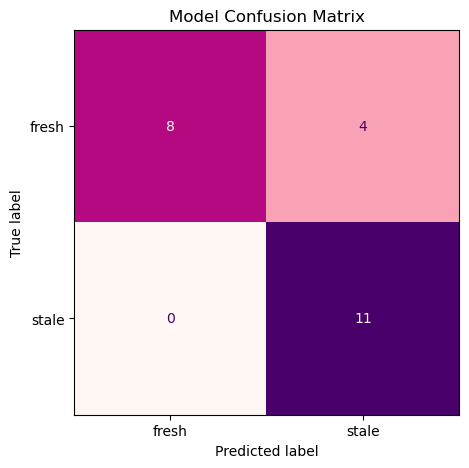

Model Evaluation:
Accuracy Score: 82.61
Precision Score: 86.67
Recall Score: 83.33
F1 Score: 82.31


In [14]:
# Display Confusion Matrix
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax, cmap='RdPu')
disp.ax_.set_xticklabels(states)
disp.ax_.set_yticklabels(states)
disp.im_.colorbar.remove()
ax.set_title('Model Confusion Matrix')
plt.show()

# Print Evaluation scores
print('Model Evaluation:')
print(f'Accuracy Score: {accuracy_score(y_true, y_pred)*100:.2f}')
print(f'Precision Score: '
      f'{precision_score(y_true, y_pred, average="macro")*100:.2f}')
print(f'Recall Score: '
      f'{recall_score(y_true, y_pred, average="macro")*100:.2f}')
print(f'F1 Score: {f1_score(y_true, y_pred,  average="macro")*100:.2f}')

In [15]:
shap_explainer = shap.Explainer(best_model.predict, df_X_test_scaled, feature_names=df_X_test_scaled.columns)
shap_values = shap_explainer(df_X_test_scaled.iloc[:, :])
shap_explanation = shap.Explanation(shap_values.values[:, :],
                                    shap_values.base_values[0],
                                    shap_values.data,
                                    feature_names=df_X_test_scaled.columns)

Permutation explainer: 24it [00:10,  5.33s/it]                


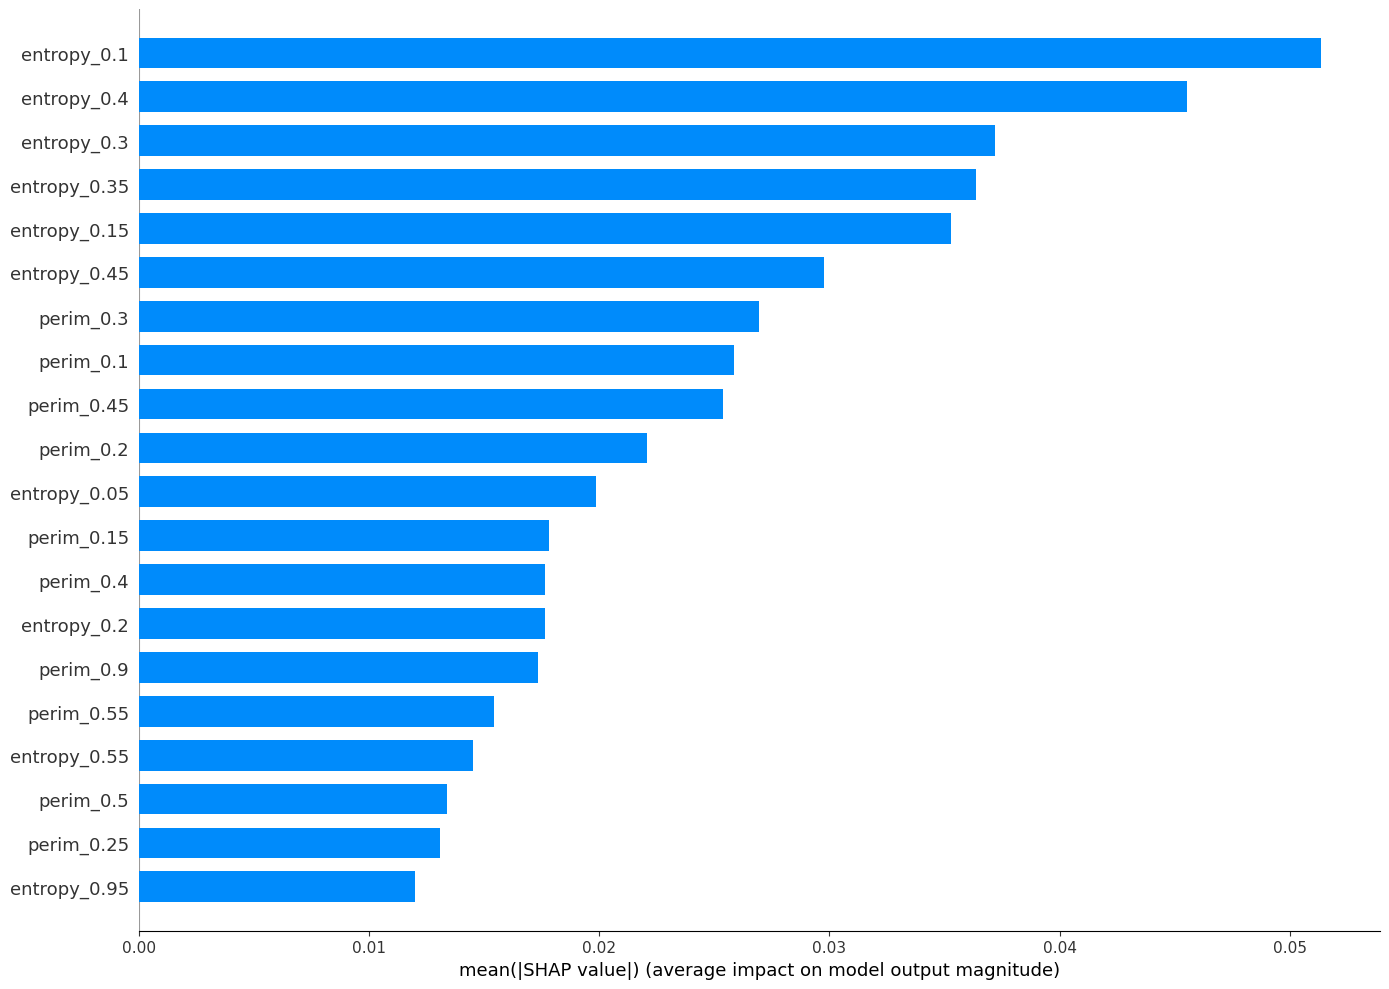

In [16]:
shap.summary_plot(shap_explanation, plot_type='bar', plot_size=(14, 10))

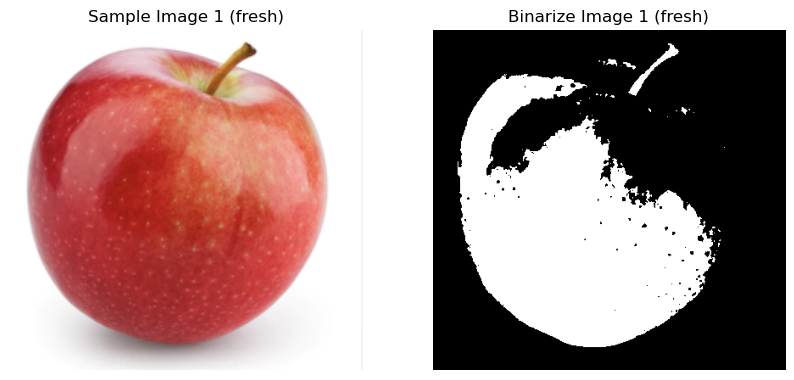

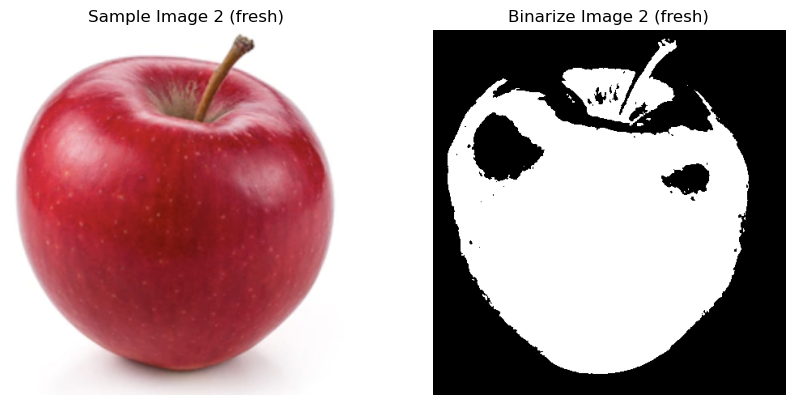

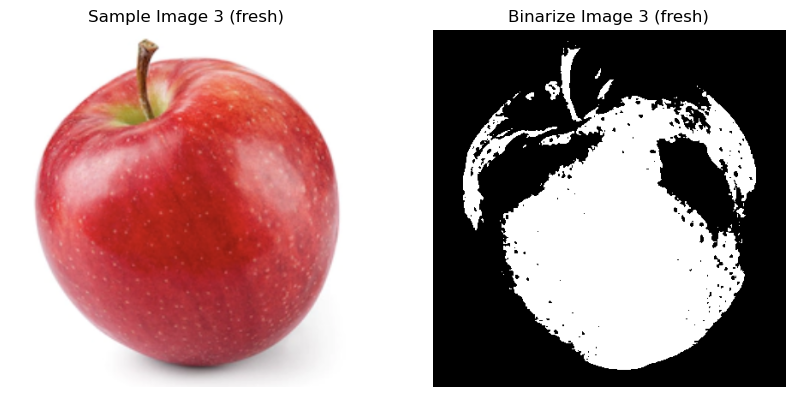

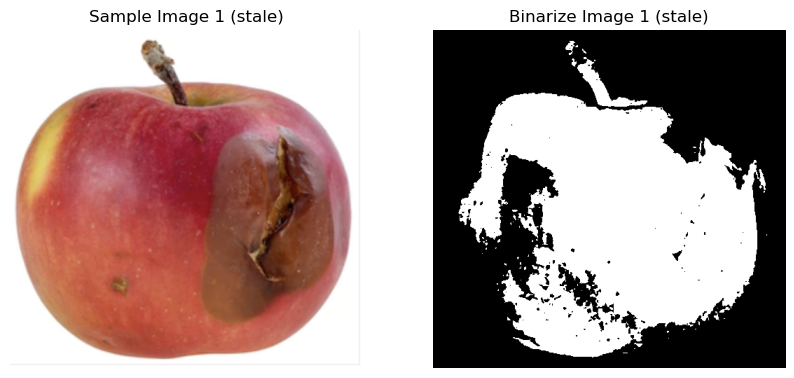

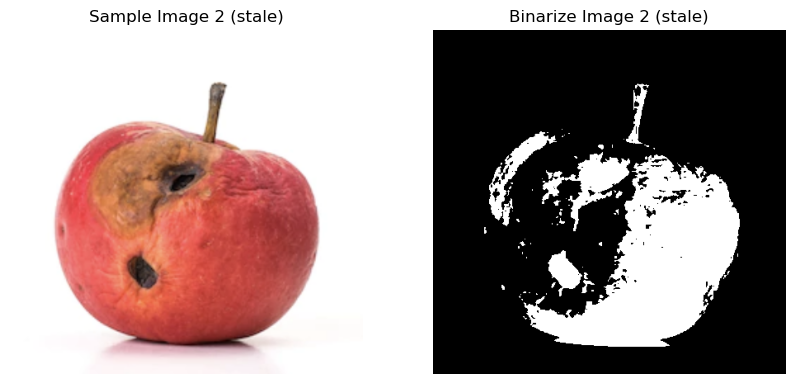

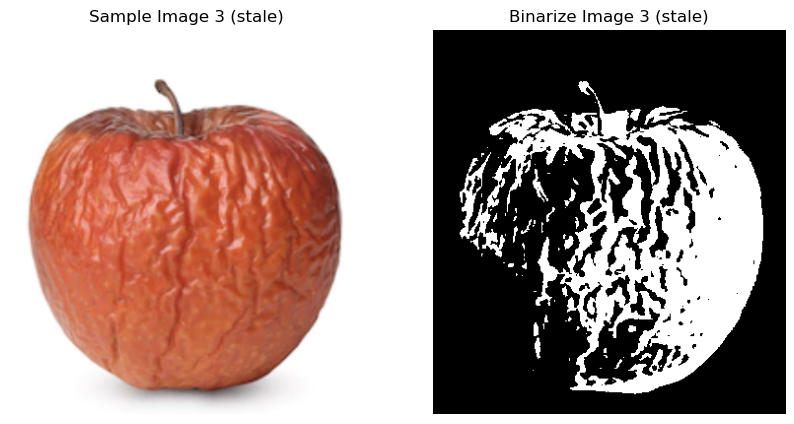

In [17]:
# Loop through all fruit status
for state in states:
    state_path = os.path.join(folder_path, state)
    img_list = os.listdir(state_path)

    # Loop through all images in the state
    for idx, img in enumerate(img_list):
        # Read the raw image
        img_path = os.path.join(state_path, img)
        img_raw = imread(img_path)
        
        # Preprocess image by grayscaling and binarizing
        img_gs = rgb2gray(img_raw[:, :, :3])
        img_bw = (img_gs < 0.45)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img_raw, cmap='gray')
        ax[0].set_title(f"Sample Image {idx+1} ({state})")
        ax[0].set_axis_off()
        ax[1].imshow(img_bw, cmap='gray')
        ax[1].set_title(f"Binarize Image {idx+1} ({state})")
        ax[1].set_axis_off()
        plt.show()
        
        
        # Show only 2
        if idx == 2:
            break

# Extra

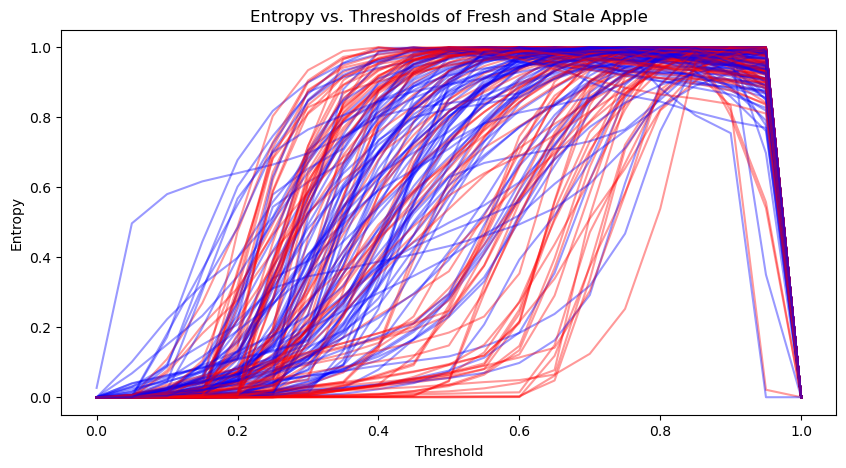

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(len(entropy_fresh)):
    # Plot entropy of damage
    entropy = entropy_fresh[i]
    ax.plot(thresholds, entropy, color='red', alpha=0.4)
    
    # Plot entropy of undamage
    entropy = entropy_stale[i]
    ax.plot(thresholds, entropy, color='blue', alpha=0.4)

ax.set_title('Entropy vs. Thresholds of Fresh and Stale Apple')
ax.set_ylabel('Entropy')
ax.set_xlabel('Threshold')
plt.show()

(array([1.2000e+01, 1.8610e+03, 7.0600e+03, 5.7970e+03, 4.9540e+03,
        2.9240e+03, 1.8540e+03, 9.5400e+02, 8.8800e+02, 1.6896e+04]),
 array([0.05194588, 0.14675129, 0.24155671, 0.33636212, 0.43116753,
        0.52597294, 0.62077835, 0.71558376, 0.81038918, 0.90519459,
        1.        ]),
 <BarContainer object of 10 artists>)

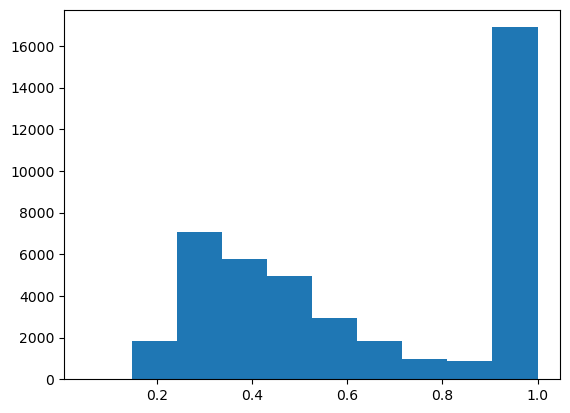

In [93]:
fresh_sample = imread('./data/fresh/Screen Shot 2018-06-08 at 5.10.37 PM.png')
fresh_gs = rgb2gray(fresh_sample[:, :, :3])
plt.hist(fresh_gs.flatten(), bins=10)

(array([  837.,  6571.,  8401.,  5931.,  3262.,  2112.,  1590.,   841.,
         1080., 29827.]),
 array([0.20913686, 0.28822318, 0.36730949, 0.4463958 , 0.52548212,
        0.60456843, 0.68365475, 0.76274106, 0.84182737, 0.92091369,
        1.        ]),
 <BarContainer object of 10 artists>)

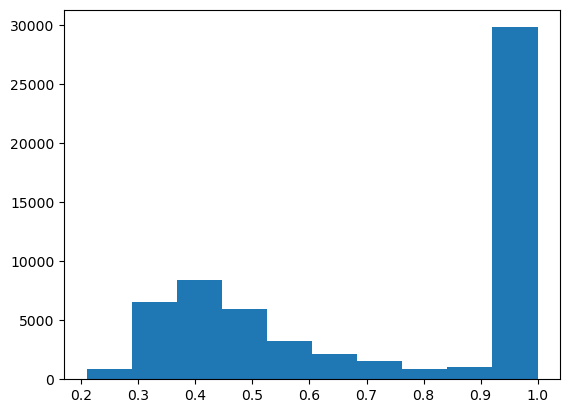

In [83]:
stale_sample = imread('./data/stale/Screen Shot 2018-06-07 at 2.23.02 PM.png')
stale_gs = rgb2gray(stale_sample[:, :, :3])
plt.hist(stale_gs.flatten(), bins=10)